# Iris multiclass classification problem

In [1]:
import sys
import os
import random
import csv
from pprint import pprint
from typing import Dict, List, Tuple

import matplotlib as mplt
from matplotlib import pyplot as plt

module_path = os.path.abspath(os.path.join("..", ".."))
sys.path.append(module_path)

from perceptron.model import Model, cross_validation
from perceptron.layer import Layer
from perceptron.metric import TopKCategoricalAccuracy
from perceptron.activation import (
    Heavyside,
    Linear,
    Relu,
    LeakyRelu,
    Sigmoid,
    Tanh,
    Softmax,
)
from perceptron.data_util import transpose, to_categorical


In [2]:
with open("iris.csv", "rt") as f:
    data = [
        [float(value) for value in features] + [target]
        for *features, target in [line for line in csv.reader(f) if line]
    ]

*features, targets = transpose(data)
features = transpose(features)
mapping, targets = to_categorical(targets)

print("Labels mapping:")
for label in mapping:
    print(label, mapping[label])


Labels mapping:
Iris-setosa [1, 0, 0]
Iris-versicolor [0, 1, 0]
Iris-virginica [0, 0, 1]


# Helper function
Prints result of a comparisson, expects dictionary of training histories

In [3]:
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("svg")

Name = str
History = Dict[str, List]


def plot(histories: Dict[Name, History], figsize: Tuple[int] = (10, 4)):

    metrics = set()
    for name in histories:
        metrics.update(histories[name].keys())

    fig = plt.figure(figsize=figsize)
    gs = mplt.gridspec.GridSpec(1, len(metrics))

    for subplot_index, metric in enumerate(sorted(metrics)):
        ax = fig.add_subplot(gs[subplot_index])

        min_ = None
        max_ = None

        for name in histories:
            history = histories[name][metric]
            ax.plot(range(epochs + 1), history, label=name)

            min_ = min(history) if min_ is None else min(min_, min(history))
            max_ = max(history) if max_ is None else max(max_, max(history))

        scale = abs(max_ - min_) * 0.1

        ax.set_ylim(
            bottom=min_ + scale if min_ < 0 else min_ - scale,
            top=max_ - scale if max_ < 0 else max_ + scale,
        )
        ax.grid()
        ax.legend()
        ax.set_title(metric)

    plt.show()


# Optimizers with single layer model

Training gd[lr=0.3]: 100% |████████████████████████████████████████| 50/50, categorical_accuracy=0.98, mae=0.0321, top_2_cat_acc=1  
Training momentum[lr=0.1]: 100% |████████████████████████████████████████| 50/50, categorical_accuracy=0.98, mae=0.0221, top_2_cat_acc=1  
Training nesterov[lr=0.1]: 100% |████████████████████████████████████████| 50/50, categorical_accuracy=0.98, mae=0.0223, top_2_cat_acc=1  
Training adagrad[lr=1.0]: 100% |████████████████████████████████████████| 50/50, categorical_accuracy=0.98, mae=0.0281, top_2_cat_acc=1  
Training rmsprop[lr=0.1]: 100% |████████████████████████████████████████| 50/50, categorical_accuracy=0.98, mae=0.0205, top_2_cat_acc=1  
Training adam[lr=0.1]: 100% |████████████████████████████████████████| 50/50, categorical_accuracy=0.98, mae=0.0215, top_2_cat_acc=1  


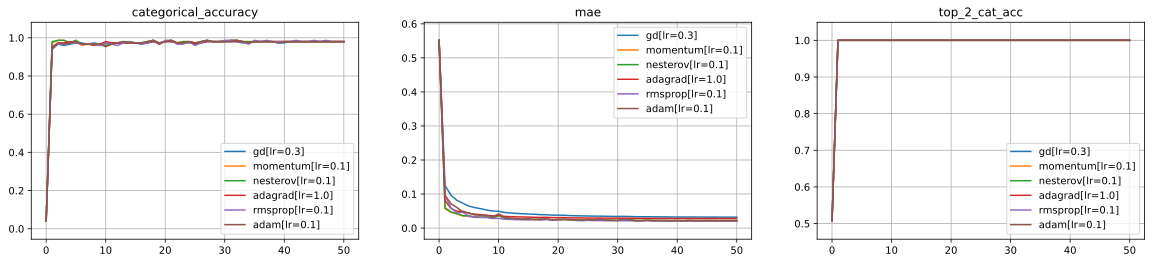

In [4]:
def model_factory():
    input_size = 4
    layer_init_method = "he"

    model = Model(normalizer="zscore")

    model.add(Layer(input_size, layer_size=3, init_method=layer_init_method))
    model.add(Softmax())

    return model


specs = [
    {"optimizer": "gd", "base_learning_rate": 0.3},
    {"optimizer": "momentum", "base_learning_rate": 0.1},
    {"optimizer": "nesterov", "base_learning_rate": 0.1},
    {"optimizer": "adagrad", "base_learning_rate": 1.0},
    {"optimizer": "rmsprop", "base_learning_rate": 0.1},
    {"optimizer": "adam", "base_learning_rate": 0.1},
]


metrics = ("categorical_accuracy", TopKCategoricalAccuracy(k=2), "mae")
histories = {}
for spec in specs:
    name = f"{spec['optimizer']}[lr={spec['base_learning_rate']}]"
    random.seed(0)

    model = model_factory()
    model.compile(spec["optimizer"])

    epochs = 50
    history = model.train(
        training_inputs=features,
        training_targets=targets,
        epochs=epochs,
        loss_function="categorical_crossentropy",
        batch_size=2,
        base_learning_rate=spec["base_learning_rate"],
        learning_rate_decay="linear",
        metrics=metrics,
        session_name=name,
    )
    histories[name] = history


plot(histories, figsize=(20, 4))


# Activations with single layer model

Training Heavyside[mse]: 100% |████████████████████████████████████████| 50/50, categorical_accuracy=0.76, mae=0.151, top_2_cat_acc=0.993  
Training Linear[mse]: 100% |████████████████████████████████████████| 50/50, categorical_accuracy=0.853, mae=0.237, top_2_cat_acc=0.987
Training Relu[mse]: 100% |████████████████████████████████████████| 50/50, categorical_accuracy=0.947, mae=0.149, top_2_cat_acc=1  
Training LeakyRelu[mse]: 100% |████████████████████████████████████████| 50/50, categorical_accuracy=0.947, mae=0.182, top_2_cat_acc=1   
Training Sigmoid[binary_crossentropy]: 100% |████████████████████████████████████████| 50/50, categorical_accuracy=0.927, mae=0.158, top_2_cat_acc=1  
Training Tanh[mse]: 100% |████████████████████████████████████████| 50/50, categorical_accuracy=0.833, mae=0.259, top_2_cat_acc=0.967
Training Softmax[categorical_crossentropy]: 100% |████████████████████████████████████████| 50/50, categorical_accuracy=0.973, mae=0.0681, top_2_cat_acc=1 


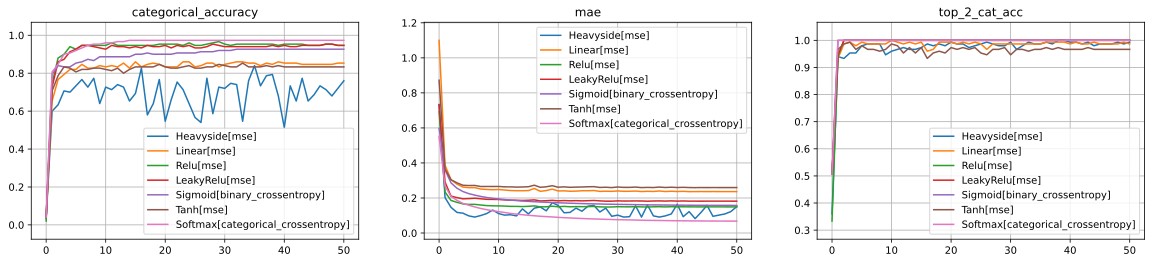

In [5]:
specs = [
    {"activation": Heavyside(), "loss": "mse"},
    {"activation": Linear(), "loss": "mse"},
    {"activation": Relu(), "loss": "mse"},
    {"activation": LeakyRelu(), "loss": "mse"},
    {"activation": Sigmoid(), "loss": "binary_crossentropy"},
    {"activation": Tanh(), "loss": "mse"},
    {"activation": Softmax(), "loss": "categorical_crossentropy"},
]

metrics = ("categorical_accuracy", TopKCategoricalAccuracy(k=2), "mae")
histories = {}
for spec in specs:
    name = f"{spec['activation'].__class__.__name__}[{spec['loss']}]"
    random.seed(0)

    input_size = 4
    layer_init_method = "he"

    model = Model(normalizer="zscore")
    model.add(Layer(input_size, layer_size=3, init_method=layer_init_method))
    model.add(spec["activation"])

    model.compile("adam")

    epochs = 50
    history = model.train(
        training_inputs=features,
        training_targets=targets,
        epochs=epochs,
        loss_function="mse",
        batch_size=2,
        base_learning_rate=0.01,
        learning_rate_decay="linear",
        metrics=metrics,
        session_name=name,
    )
    histories[name] = history

plot(histories, figsize=(20, 4))


# Loss functions with single layer model

Training mse: 100% |████████████████████████████████████████| 50/50, categorical_accuracy=0.973, mae=0.0681, top_2_cat_acc=1 
Training msle: 100% |████████████████████████████████████████| 50/50, categorical_accuracy=0.973, mae=0.067, top_2_cat_acc=1  
Training mae: 100% |████████████████████████████████████████| 50/50, categorical_accuracy=0.973, mae=0.0463, top_2_cat_acc=1 
Training binary_crossentropy: 100% |████████████████████████████████████████| 50/50, categorical_accuracy=0.973, mae=0.0546, top_2_cat_acc=1 
Training categorical_crossentropy: 100% |████████████████████████████████████████| 50/50, categorical_accuracy=0.973, mae=0.0572, top_2_cat_acc=1  


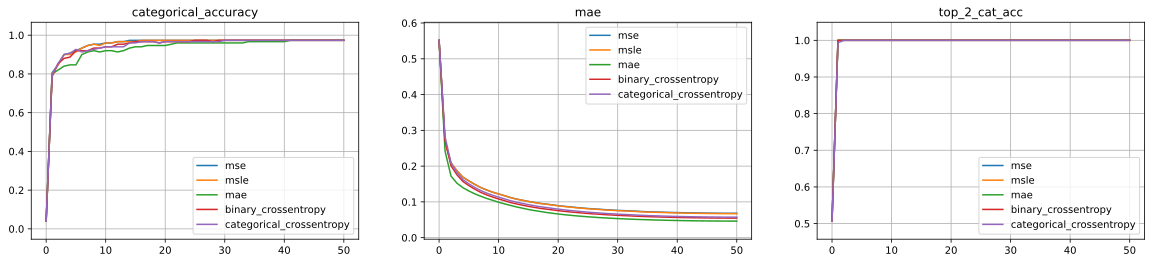

In [6]:
def model_factory():
    input_size = 4
    layer_init_method = "he"

    model = Model(normalizer="zscore")

    model.add(Layer(input_size, layer_size=3, init_method=layer_init_method))
    model.add(Softmax())

    return model

specs = [
    {"loss": "mse"},
    {"loss": "msle"},
    {"loss": "mae"},
    {"loss": "binary_crossentropy"},
    {"loss": "categorical_crossentropy"},
]

metrics = ("categorical_accuracy", TopKCategoricalAccuracy(k=2), "mae")
histories = {}
for spec in specs:
    name = spec['loss']
    random.seed(0)

    model = model_factory()
    model.compile("adam")

    epochs = 50
    history = model.train(
        training_inputs=features,
        training_targets=targets,
        epochs=epochs,
        loss_function=spec["loss"],
        batch_size=2,
        base_learning_rate=0.01,
        learning_rate_decay="linear",
        metrics=metrics,
        session_name=name,
    )
    histories[name] = history


plot(histories, figsize=(20, 4))


# Batch sizes with single layer model

Training 1: 100% |████████████████████████████████████████| 50/50, categorical_accuracy=0.973, mae=0.0425, top_2_cat_acc=1 
Training 2: 100% |████████████████████████████████████████| 50/50, categorical_accuracy=0.973, mae=0.0386, top_2_cat_acc=1 
Training 4: 100% |████████████████████████████████████████| 50/50, categorical_accuracy=0.973, mae=0.0354, top_2_cat_acc=1 
Training 8: 100% |████████████████████████████████████████| 50/50, categorical_accuracy=0.98, mae=0.0324, top_2_cat_acc=1  
Training 16: 100% |████████████████████████████████████████| 50/50, categorical_accuracy=0.98, mae=0.029, top_2_cat_acc=1   
Training 32: 100% |████████████████████████████████████████| 50/50, categorical_accuracy=0.98, mae=0.0268, top_2_cat_acc=1  
Training 64: 100% |████████████████████████████████████████| 50/50, categorical_accuracy=0.98, mae=0.0266, top_2_cat_acc=1  


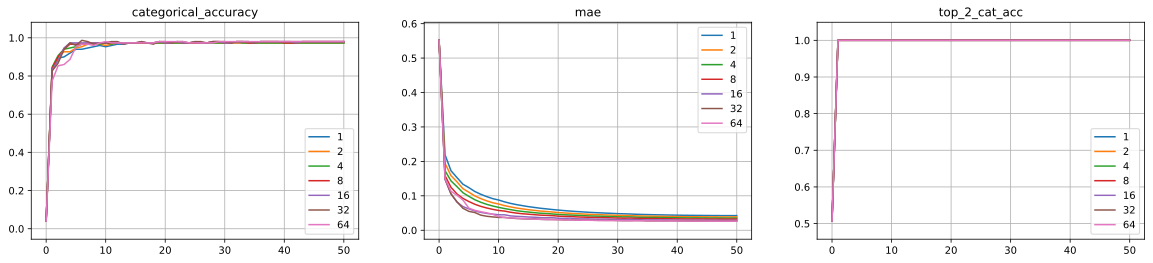

In [7]:


def model_factory():
    input_size = 4
    layer_init_method = "he"

    model = Model(normalizer="zscore")

    model.add(Layer(input_size, layer_size=3, init_method=layer_init_method))
    model.add(Softmax())

    return model

base_learning_rate = 0.01

metrics = ("categorical_accuracy", TopKCategoricalAccuracy(k=2), "mae")
histories = {}
for batch_size in [1, 2, 4, 8, 16, 32, 64]:
    name = str(batch_size)
    random.seed(0)

    model = model_factory()
    model.compile("adam")

    epochs = 50
    history = model.train(
        training_inputs=features,
        training_targets=targets,
        epochs=epochs,
        loss_function="categorical_crossentropy",
        batch_size=batch_size,
        base_learning_rate=base_learning_rate * batch_size,
        learning_rate_decay="linear",
        metrics=metrics,
        session_name=name,
    )
    histories[name] = history


plot(histories, figsize=(20, 4))


# Multi layer model

Training: 100% |████████████████████████████████████████| 50/50, categorical_accuracy=0.987, mae=0.0173, top_2_cat_acc=1


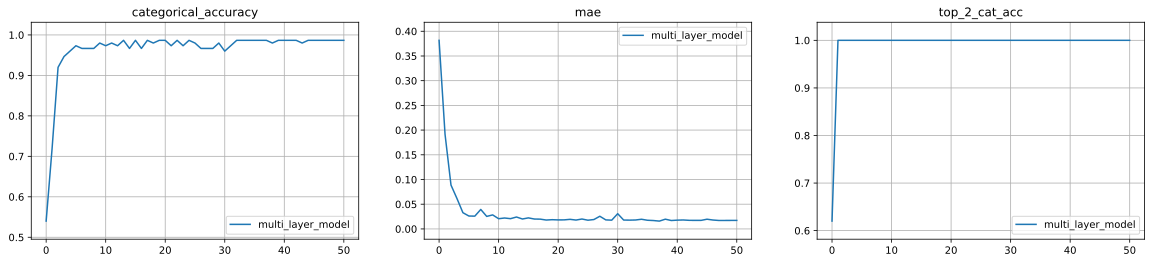

In [8]:
random.seed(0)


def model_factory():
    input_size = 4
    layer_init_method = "he"

    model = Model(normalizer="zscore")

    model.add(Layer(input_size, layer_size=4, init_method=layer_init_method))
    model.add(LeakyRelu())
    model.add(Layer(input_size=4, layer_size=4, init_method=layer_init_method))
    model.add(LeakyRelu())
    model.add(Layer(input_size=4, layer_size=3, init_method=layer_init_method))
    model.add(Softmax())

    return model


optimizer = "adam"
epochs = 50
batch_size = 32
training_params = dict(
    training_inputs=features,
    training_targets=targets,
    epochs=epochs,
    loss_function="categorical_crossentropy",
    batch_size=batch_size,
    base_learning_rate=0.01 * batch_size,
    learning_rate_decay="linear",
    metrics=["categorical_accuracy", TopKCategoricalAccuracy(k=2), "mae"],
)

model = model_factory()
model.compile(optimizer)
history = model.train(**training_params)

plot({"multi_layer_model": history}, figsize=(20, 4))


# Cross validating multi layer model

Training: 100% |████████████████████████████████████████| 50/50, categorical_accuracy=1, mae=0.00652, top_2_cat_acc=1, val_categorical_accuracy=0.94, val_mae=0.043, val_top_2_cat_acc=1     
Training: 100% |████████████████████████████████████████| 50/50, categorical_accuracy=1, mae=0.00447, top_2_cat_acc=1, val_categorical_accuracy=0.94, val_mae=0.0383, val_top_2_cat_acc=1  
Training: 100% |████████████████████████████████████████| 50/50, categorical_accuracy=0.98, mae=0.0235, top_2_cat_acc=1, val_categorical_accuracy=0.98, val_mae=0.0234, val_top_2_cat_acc=1   


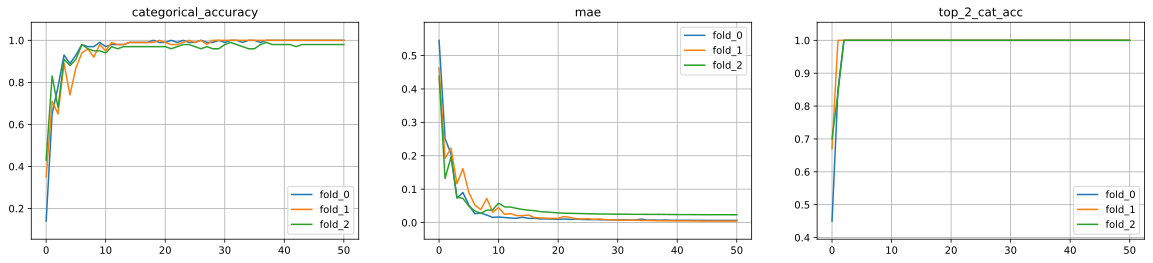

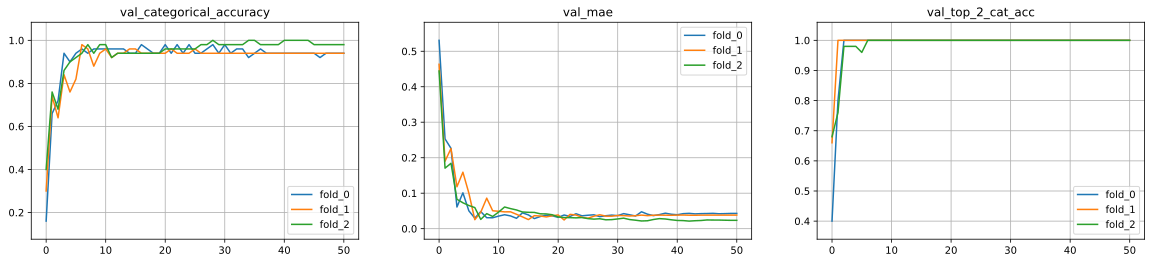

In [9]:
random.seed(0)

if training_params.get("inputs") is None:
    training_params["inputs"] = training_params.pop("training_inputs")
if training_params.get("targets") is None:
    training_params["targets"] = training_params.pop("training_targets")
metrics = training_params["metrics"]

history = cross_validation(
    model_factory=model_factory, fold_count=3, optimizer=optimizer, **training_params
)


train_histories = {}
val_histories = {}
for fold_index, fold in enumerate(history):
    name = f"fold_{fold_index}"
    train_histories[name] = {}
    val_histories[name] = {}

    for metric in metrics:
        if not isinstance(metric, str):
            metric = metric.name
        val_histories[name]["val_" + metric] = fold["val_" + metric]
        train_histories[name][metric] = fold[metric]

plot(train_histories, figsize=(20, 4))
plot(val_histories, figsize=(20, 4))
